Ce notebook a été entièrement réalise par Enzo Nguyen

In [1]:
import gdown
import os
import glob

# 1. On installe gdown si besoin
try:
    import gdown
except ImportError:
    !pip install -q gdown
    import gdown

# On définit le nom du dossier
dossier_nom = "redshift"
url = "https://drive.google.com/drive/folders/1-tQH6rfB1XoF7ml98yqVn7Z2IQwGMUdK?usp=sharing"

# 2. LOGIQUE DE TÉLÉCHARGEMENT
if os.path.exists(dossier_nom):
    print(f"✅ Le dossier '{dossier_nom}' est déjà présent. Pas besoin de retélécharger !")
else:
    print(f"📥 Dossier introuvable. Téléchargement en cours...")
    gdown.download_folder(url, quiet=False, use_cookies=False)
    print("✅ Téléchargement terminé !")

# 3. CRÉATION DE LA LISTE DES FICHIERS (C'est ici que ça plantait avant)
# On scanne le dossier pour créer la liste 'dossier_local' quoi qu'il arrive
pattern = os.path.join(dossier_nom, "*") # ex: redshift/*
dossier_local = glob.glob(pattern)

# 4. AFFICHAGE JOLI
print(f"\nSuccès ! {len(dossier_local)} fichiers trouvés dans '{dossier_nom}'.")
print("Détail des fichiers :")

for chemin in dossier_local:
    # On extrait le nom du dossier et le nom du fichier
    dossier = os.path.dirname(chemin)   # ex: redshift
    fichier = os.path.basename(chemin)  # ex: COSMOS_...npz
    
    # Ton format demandé
    print(f"[{dossier}] :\t {fichier}")

✅ Le dossier 'redshift' est déjà présent. Pas besoin de retélécharger !

Succès ! 8 fichiers trouvés dans 'redshift'.
Détail des fichiers :
[redshift] :	 COSMOS_v11_uijk_0020_spec_D.npz
[redshift] :	 XMM_LSS_v11_uijk_0006_spec_D.npz
[redshift] :	 XMM_LSS_v11_uijk_0162_phot_D.npz
[redshift] :	 COSMOS_v11_uijk_0213_photo_UD.npz
[redshift] :	 XMM_LSS_v11_uijk_0177_spec_UD.npz
[redshift] :	 XMM_LSS_v11_uijk_0162_phot_UD.npz
[redshift] :	 COSMOS_v11_uijk_0073_spec_UD.npz
[redshift] :	 COSMOS_v11_uijk_0001_photo_D.npz


In [2]:
import os

print("--- INSPECTION APPROFONDIE DE 'redshift' ---")

dossier_cible = "redshift"
est_vide = True

# os.walk permet de descendre dans tous les sous-dossiers
for root, dirs, files in os.walk(dossier_cible):
    for name in files:
        est_vide = False
        chemin_complet = os.path.join(root, name)
        taille = os.path.getsize(chemin_complet)
        print(f"📄 TROUVÉ : {chemin_complet} | Taille : {taille} octets")

if est_vide:
    print("⚠️ LE DOSSIER EST VIDE.")
    print("Cela veut dire que Google a bloqué le téléchargement du contenu.")
    print("Solution : Vérifie que les fichiers DANS le dossier Drive sont aussi en 'Public'.")

--- INSPECTION APPROFONDIE DE 'redshift' ---
📄 TROUVÉ : redshift/COSMOS_v11_uijk_0020_spec_D.npz | Taille : 2219001 octets
📄 TROUVÉ : redshift/XMM_LSS_v11_uijk_0006_spec_D.npz | Taille : 1184118 octets
📄 TROUVÉ : redshift/XMM_LSS_v11_uijk_0162_phot_D.npz | Taille : 934811082 octets
📄 TROUVÉ : redshift/COSMOS_v11_uijk_0213_photo_UD.npz | Taille : 65475010 octets
📄 TROUVÉ : redshift/XMM_LSS_v11_uijk_0177_spec_UD.npz | Taille : 1923288 octets
📄 TROUVÉ : redshift/XMM_LSS_v11_uijk_0162_phot_UD.npz | Taille : 810662442 octets
📄 TROUVÉ : redshift/COSMOS_v11_uijk_0073_spec_UD.npz | Taille : 1775490 octets
📄 TROUVÉ : redshift/COSMOS_v11_uijk_0001_photo_D.npz | Taille : 1781534366 octets


1) Importation des librairies

In [57]:
import numpy as np                 # Pour la manipulation des tableaux (arrays)
import pandas as pd                # Pour lire ton catalogue (les labels CSV)
import matplotlib.pyplot as plt    # Pour faire les graphiques
import glob                        # Pour lister les fichiers dans un dossier
import tensorflow as tf            # Le framework de deep learning
from tensorflow import keras       # L'API haut-niveau (ResNet, ViT, entraînement)
from keras import layers

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Outils pour les métriques et la préparation
from sklearn.model_selection import train_test_split # Pour séparer les données
from sklearn.linear_model import LinearRegression # Pour la régression linéaire
from sklearn.metrics import mean_squared_error, r2_score  # Pour le R² et RMSE

2) Définitions

In [58]:
# --- 1. Fonction de normalisation (TÂCHE 2) ---
def custom_norm(x):
    """
    Applique la normalisation n(x) = sign(x) * sqrt(|x| + 1) - 1
    """
    return np.sign(x) * np.sqrt(np.abs(x) + 1) - 1

# --- 2. Constantes pour le binning (TÂCHE 3) ---
Z_MIN = 0.0
Z_MAX = 4.0
NUM_BINS = 400
# Crée 401 "bords" pour définir 400 bins
BINS = np.linspace(Z_MIN, Z_MAX, NUM_BINS + 1)

# --- Constantes pour le Flag (TÂCHE 1) ---
MAG_COLS = ['u', 'uS', 'g', 'r', 'i', 'z', 'y', 'J', 'H', 'Ks']

3) Chargement des fichiers

In [59]:
# --- 3. Boucle de chargement (Utilisant 'flag') ---
fichiers_npz = glob.glob('*.npz')
cosmos_files = [f for f in fichiers_npz if "COSMOS" in f]

# Listes séparées pour train et test
train_cubes_list = []
train_infos_list = []
train_flag_list = [] # On charge le 'flag' séparé

test_cubes_list = []
test_infos_list = []
test_flag_list = [] # On charge le 'flag' séparé

print(f"Analyse de {len(cosmos_files)} fichiers COSMOS...")

for fichier in cosmos_files:
    try:
        data = np.load(fichier, allow_pickle=True)
        info_fields = data['info'].dtype.names
        
        # Sépare les fichiers "train" (ont ZSPEC)
        if 'ZSPEC' in info_fields:
            print(f"  -> Fichier 'train' trouvé: {fichier}")
            train_cubes_list.append(data['cube'])
            train_infos_list.append(data['info'])
            train_flag_list.append(data['flag'])
        # Et les fichiers "test" (n'ont pas ZSPEC)
        else:
            print(f"  -> Fichier 'test' trouvé: {fichier}")
            test_cubes_list.append(data['cube'])
            test_infos_list.append(data['info'])
            test_flag_list.append(data['flag'])
            
    except Exception as e:
        print(f"❌ Erreur en chargeant {fichier}: {e}")

print("\nChargement terminé. Prêt pour la concaténation et le traitement.")

Analyse de 4 fichiers COSMOS...
  -> Fichier 'test' trouvé: COSMOS_v11_uijk_0001_photo_D.npz
  -> Fichier 'train' trouvé: COSMOS_v11_uijk_0020_spec_D.npz
  -> Fichier 'train' trouvé: COSMOS_v11_uijk_0073_spec_UD.npz
  -> Fichier 'test' trouvé: COSMOS_v11_uijk_0213_photo_UD.npz

Chargement terminé. Prêt pour la concaténation et le traitement.


4) Traitement du jeu d'entrainement

In [60]:
# --- 4. Traitement du jeu d'entraînement (Intégration des étapes) ---
if train_infos_list:
    # Concaténer tous les objets d'entraînement
    X_train_raw = np.concatenate(train_cubes_list, axis=0)
    infos_train_raw = np.concatenate(train_infos_list, axis=0)
    y_train_zspec_raw = infos_train_raw['ZSPEC']
    flags_train_raw = np.concatenate(train_flag_list, axis=0)
    
    # --- TÂCHE 3 (Filtrage) : Garder uniquement 0 <= ZSPEC <= 4 ---
    z_filter_mask = (y_train_zspec_raw >= Z_MIN) & (y_train_zspec_raw <= Z_MAX)
    
    X_train = X_train_raw[z_filter_mask]
    infos_train = infos_train_raw[z_filter_mask].copy()
    y_train_zspec = y_train_zspec_raw[z_filter_mask]
    flags_train = flags_train_raw[z_filter_mask]
    
    print(f"\nObjets d'entraînement (ZSPEC) : {len(y_train_zspec)} (après filtrage 0 <= z <= 4)")

    # --- TÂCHE 1 (Flag == 5) : Utilise 'flags_train' ---
    print("  -> Tâche 1: Vérification de 'flag' == 5...")
    flag_5_mask = flags_train == 5
    num_flagged = np.sum(flag_5_mask)
    
    if num_flagged > 0:
        print(f"    -> {num_flagged} objets trouvés. Magnitudes mises à NaN.")
        for col in MAG_COLS:
            if col in infos_train.dtype.names:
                infos_train[col][flag_5_mask] = np.nan
    else:
        print("    -> Aucun objet avec flag == 5.")
        
    # --- TÂCHE 2 (Normalisation) : Appliquer la normalisation aux images ---
    print("  -> Tâche 2: Normalisation des images (X_train)...")
    X_train = custom_norm(X_train)
    
    # --- TÂCHE 3 (Binarisation) : Convertir y_train_zspec en one-hot ---
    print(f"  -> Tâche 3: Binarisation de ZSPEC en {NUM_BINS} classes...")
    bin_indices = np.digitize(y_train_zspec, BINS)
    bin_indices[y_train_zspec == Z_MAX] = NUM_BINS
    bin_indices_0_based = bin_indices - 1
    
    num_objects = len(y_train_zspec)
    y_train = np.zeros((num_objects, NUM_BINS), dtype=np.int8)
    y_train[np.arange(num_objects), bin_indices_0_based] = 1
    
    print("\n--- Set d'entraînement Prêt ---")
    print(f"X_train (images normalisées): {X_train.shape}")
    print(f"y_train (redshifts one-hot): {y_train.shape}")

else:
    print("\n--- Aucun fichier d'entraînement (AVEC ZSPEC) trouvé. ---")


Objets d'entraînement (ZSPEC) : 24 (après filtrage 0 <= z <= 4)
  -> Tâche 1: Vérification de 'flag' == 5...
    -> Aucun objet avec flag == 5.
  -> Tâche 2: Normalisation des images (X_train)...
  -> Tâche 3: Binarisation de ZSPEC en 400 classes...

--- Set d'entraînement Prêt ---
X_train (images normalisées): (24, 64, 64, 9)
y_train (redshifts one-hot): (24, 400)


5) Traitement du jeu de test

In [61]:
# --- 5. Traitement du jeu de test (Intégration des étapes) ---
if test_infos_list:
    X_test = np.concatenate(test_cubes_list, axis=0)
    infos_test = np.concatenate(test_infos_list, axis=0).copy()
    y_test = infos_test['ZPHOT'] # Référence photométrique
    flags_test = np.concatenate(test_flag_list, axis=0)
    
    print(f"\nObjets de test (ZPHOT) : {len(y_test)}")

    # --- TÂCHE 1 (Flag == 5) : Utilise 'flags_test' ---
    print("  -> Tâche 1: Vérification de 'flag' == 5...")
    flag_5_mask = flags_test == 5
    num_flagged = np.sum(flag_5_mask)
    
    if num_flagged > 0:
        print(f"    -> {num_flagged} objets trouvés. Magnitudes mises à NaN.")
        for col in MAG_COLS:
            if col in infos_test.dtype.names:
                infos_test[col][flag_5_mask] = np.nan
    else:
        print("    -> Aucun objet avec flag == 5.")

    # --- TÂCHE 2 (Normalisation) : Appliquer la MÊME normalisation ---
    print("  -> Tâche 2: Normalisation des images (X_test)...")
    X_test = custom_norm(X_test)

    print("\n--- Set de test Prêt ---")
    print(f"X_test (images normalisées) : {X_test.shape}")
    print(f"y_test (ZPHOT référence)   : {y_test.shape}")
else:
    print("\n--- Aucun fichier de test (SANS ZSPEC) trouvé. ---")


Objets de test (ZPHOT) : 12497
  -> Tâche 1: Vérification de 'flag' == 5...
    -> Aucun objet avec flag == 5.
  -> Tâche 2: Normalisation des images (X_test)...

--- Set de test Prêt ---
X_test (images normalisées) : (12497, 64, 64, 9)
y_test (ZPHOT référence)   : (12497,)


6) Définition du modèle ViT

In [62]:
# --- 1. Définition des hyperparamètres du modèle ---
IMAGE_SIZE = 64
NUM_CHANNELS = 9
NUM_CLASSES = 400 # Vos 400 bins de redshift

# Hyperparamètres du ViT
PATCH_SIZE = 8   
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2  
EMBEDDING_DIM = 128  
NUM_HEADS = 4        
FF_DIM = 256         
NUM_TRANSFORMER_BLOCKS = 4 
DROPOUT_RATE = 0.1

print(f"--- Configuration du ViT ---")
print(f"Taille de l'image: {IMAGE_SIZE}x{IMAGE_SIZE}x{NUM_CHANNELS}")
print(f"Nombre de patchs: {NUM_PATCHES}")
print(f"Dimension d'embedding: {EMBEDDING_DIM}")


# --- 2. Création du bloc Transformer ---
def build_transformer_block(input_layer):
    inputs_normalized = layers.LayerNormalization(epsilon=1e-6)(input_layer)
    attention_output = layers.MultiHeadAttention(
        num_heads=NUM_HEADS, key_dim=EMBEDDING_DIM, dropout=DROPOUT_RATE
    )(inputs_normalized, inputs_normalized)
    skip_connection_1 = layers.Add()([attention_output, input_layer])
    inputs_normalized_2 = layers.LayerNormalization(epsilon=1e-6)(skip_connection_1)
    ff_output = layers.Dense(FF_DIM, activation="relu")(inputs_normalized_2)
    ff_output = layers.Dropout(DROPOUT_RATE)(ff_output)
    ff_output = layers.Dense(EMBEDDING_DIM)(ff_output)
    transformer_block = layers.Add()([ff_output, skip_connection_1])
    return transformer_block

# --- 3. Construction du modèle ViT complet ---
def create_vit_classifier():
    inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
    
    # Patchification (Conv2D)
    patches = layers.Conv2D(
        filters=EMBEDDING_DIM, kernel_size=PATCH_SIZE, strides=PATCH_SIZE,
        padding="valid", name="patchification"
    )(inputs)
    
    # Aplatir les patchs
    patches_reshaped = layers.Reshape(
        (NUM_PATCHES, EMBEDDING_DIM), name="flatten_patches"
    )(patches)

    # Encodage de Position
    positional_embedding = layers.Embedding(
        input_dim=NUM_PATCHES, output_dim=EMBEDDING_DIM, name="positional_embedding"
    )
    positions = tf.range(start=0, limit=NUM_PATCHES, delta=1)
    positional_encodings = positional_embedding(positions)
    embedded_patches = patches_reshaped + positional_encodings

    # Blocs Transformer
    x = embedded_patches
    for _ in range(NUM_TRANSFORMER_BLOCKS):
        x = build_transformer_block(x)
        
    # Tête de Classification
    x_normalized = layers.LayerNormalization(epsilon=1e-6)(x)
    global_average_pool = layers.GlobalAveragePooling1D()(x_normalized)
    x_dropout = layers.Dropout(0.5)(global_average_pool)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="classification_head")(x_dropout)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# --- 4. Création et Compilation du modèle ---
vit_model = create_vit_classifier()

vit_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy", # Parfait pour y_train en one-hot
    metrics=["accuracy"] 
)

vit_model.summary()

--- Configuration du ViT ---
Taille de l'image: 64x64x9
Nombre de patchs: 64
Dimension d'embedding: 128


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64, 9) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patchification      │ (None, 8, 8, 128) │     73,856 │ input_layer_1[0]… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_patches     │ (None, 64, 128)   │          0 │ patchification[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 64, 128)   │          0 │ flatten_patches[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 128)   │        256 │ add_9[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 128)   │    263,808 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 64, 128)   │          0 │ multi_head_atten… │
│                     │                   │            │ add_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 128)   │        256 │ add_10[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 64, 256)   │          0 │ dense_8[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 64, 128)   │     32,896 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_11 (Add)        │ (None, 64, 128)   │          0 │ dense_9[0][0],    │
│                     │                   │            │ add_10[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 128)   │        256 │ add_11[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 128)   │    263,808 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 64, 128)   │          0 │ multi_head_atten… │
│                     │                   │            │ add_11[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 128)   │        256 │ add_12[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 64, 256)   │          0 │ dense_10[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 1,446,672 (5.52 MB)

 Trainable params: 1,446,672 (5.52 MB)

 Non-trainable params: 0 (0.00 B)

7) Entraînement et Visualisation



--- Démarrage de l'entraînement ---
Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 1.0000 - loss: 0.2472 - val_accuracy: 0.0000e+00 - val_loss: 7.4581
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 1.0000 - loss: 0.2578 - val_accuracy: 0.0000e+00 - val_loss: 7.4306
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 1.0000 - loss: 0.2528 - val_accuracy: 0.0000e+00 - val_loss: 7.4168
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 1.0000 - loss: 0.2279 - val_accuracy: 0.0000e+00 - val_loss: 7.4208
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.9474 - loss: 0.2500 - val_accuracy: 0.0000e+00 - val_loss: 7.4256
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 1.0000 - loss: 0.2364 - val_accuracy: 0.0000e+00 - val_loss: 7.4080
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 1.0000 - loss: 0.3113 - val_accuracy: 0.0000e+00 - val_loss: 7.3817
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms

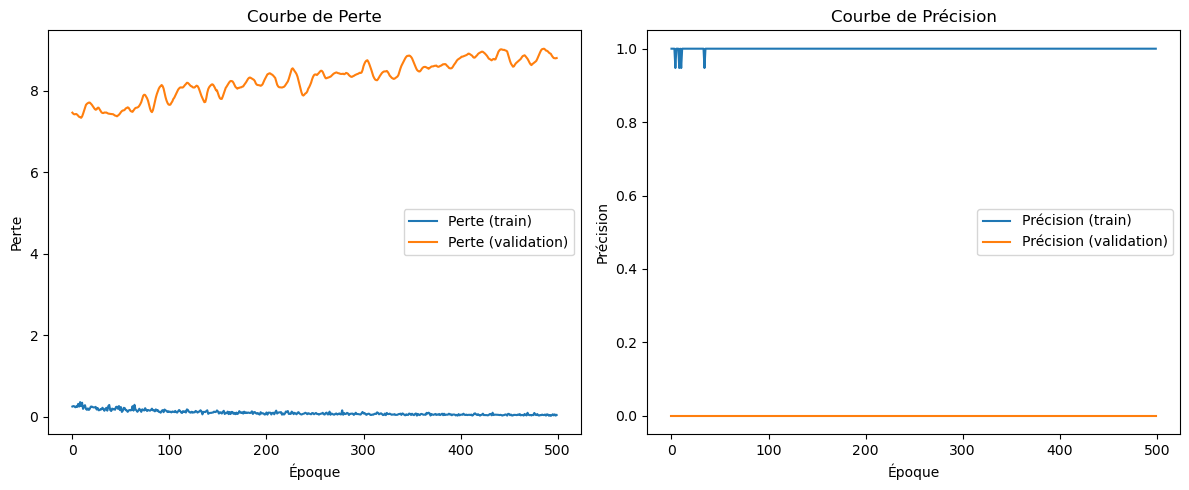

In [67]:
# --- 5. Entraînement du modèle ---
print("\n\n--- Démarrage de l'entraînement ---")

# Augmentez 'epochs' pour un vrai entraînement
history = vit_model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=500, # À augmenter (ex: 100)
    validation_split=0.2 # Garde 20% pour la validation
)

print("--- Entraînement terminé ---")

# --- 6. Visualiser les résultats ---
plt.figure(figsize=(12, 5))

# Plot de la perte (Loss)
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Perte (train)')
plt.plot(history.history['val_loss'], label='Perte (validation)')
plt.title('Courbe de Perte')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()

# Plot de la précision (Accuracy)
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Précision (train)')
plt.plot(history.history['val_accuracy'], label='Précision (validation)')
plt.title('Courbe de Précision')
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.legend()

plt.tight_layout()
plt.show()

8) Evaluation du modèle

--- Démarrage de l'évaluation sur le jeu de test ---
391/391 ━━━━━━━━━━━━━━━━━━━━ 27s 68ms/step

--- Métriques de Performance (Test Set) ---
  Biais (median(eta))     : 0.09139
  Sigma MAD (σ_mad)       : 0.41086
  Fraction d'outliers (>0.15) : 70.77%

Génération du graphique z_pred vs z_true...


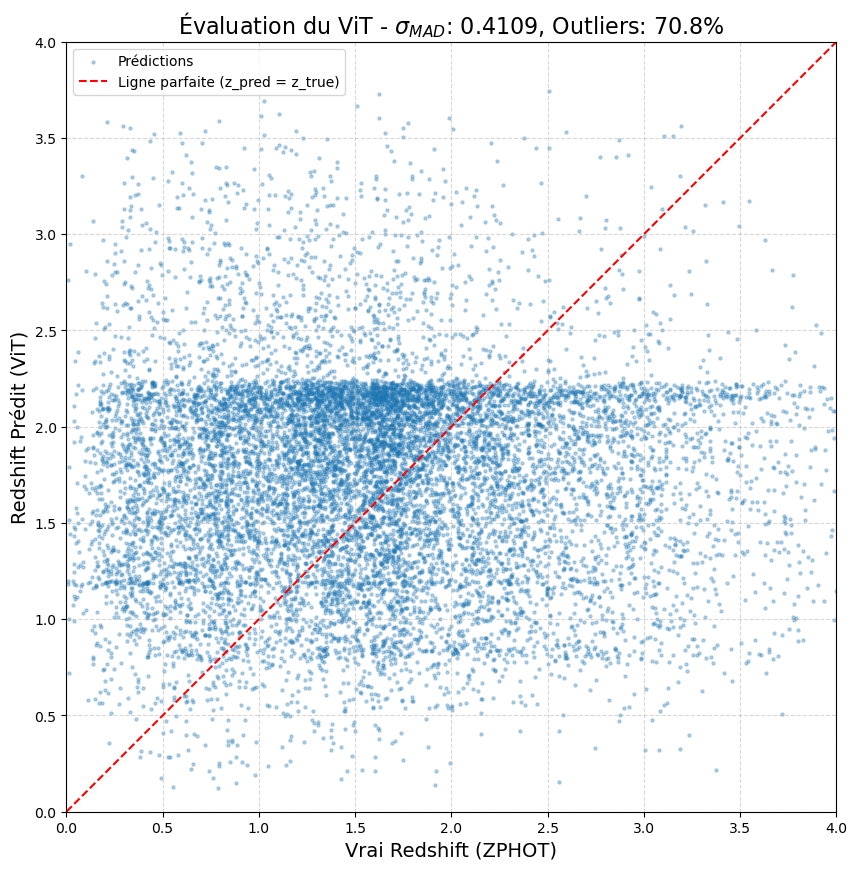

Graphique sauvegardé dans 'zphot_vs_zpred.png'


In [ ]:
print("--- Démarrage de l'évaluation sur le jeu de test ---")

# --- 1. Calcul des centres de bins ---
# BINS a 51 "bords" (pour 50 bins). Nous avons besoin des 50 "centres".
# (bord_0 + bord_1)/2, (bord_1 + bord_2)/2, ...
bin_centers = (BINS[:-1] + BINS[1:]) / 2

# bin_centers est un array de shape (50,)
# ex: [0.04, 0.12, 0.20, ...]

# --- 2. Obtenir les prédictions du modèle ---
# 'vit_model.predict()' renvoie les probabilités pour chaque classe (shape = N_objets, 50)
y_pred_probs = vit_model.predict(X_test)

# --- 3. Convertir les probabilités en redshift continu (z_pred) ---
# On fait une moyenne pondérée des centres de bin
# z_pred = sum(probabilité_bin_i * centre_bin_i) pour chaque objet
# Ceci est un produit matriciel efficace : (N, 50) @ (50, 1) -> (N, 1)
z_pred = np.dot(y_pred_probs, bin_centers)

# --- 4. Obtenir les vrais redshifts ---
# y_test est le ZPHOT, qui est notre "vérité" pour le test
z_true = y_test

# --- 5. Calcul des métriques standards (basées sur l'erreur normalisée) ---
# L'erreur normalisée 'eta' est standard en photo-z
# eta = (z_pred - z_true) / (1 + z_true)
eta = (z_pred - z_true) / (1 + z_true)

# --- BIAIS (Bias) ---
# Le Biais est la médiane de l'erreur normalisée
biais = np.median(eta)

# --- SIGMA MAD (Écart-type robuste) ---
# C'est l'écart absolu médian (MAD) de 'eta', re-normalisé
# 1.4826 * median( |eta - median(eta)| )
mad = np.median(np.abs(eta - np.median(eta)))
sigma_mad = 1.4826 * mad

# --- FRACTION D'OUTLIERS (Outlier Fraction) ---
# Un outlier est souvent défini comme |eta| > 0.15
outlier_mask = np.abs(eta) > 0.15
outlier_fraction = np.mean(outlier_mask) # La moyenne d'un masque booléen est la fraction

# --- 6. Affichage des résultats ---
print("\n--- Métriques de Performance (Test Set) ---")
print(f"  Biais (median(eta))     : {biais:.5f}")
print(f"  Sigma MAD (σ_mad)       : {sigma_mad:.5f}")
print(f"  Fraction d'outliers (>0.15) : {outlier_fraction:.2%}") # Affiche en %

# --- 7. Visualisation (z_pred vs z_true) ---
print("\nGénération du graphique z_pred vs z_true...")
plt.figure(figsize=(10, 10))
# 's=5' et 'alpha=0.3' sont utiles s'il y a beaucoup de points
plt.scatter(z_true, z_pred, s=5, alpha=0.3, label="Prédictions")
plt.plot([0, Z_MAX], [0, Z_MAX], 'r--', label="Ligne parfaite (z_pred = z_true)")
plt.xlabel("Vrai Redshift (ZPHOT)", fontsize=14)
plt.ylabel("Redshift Prédit (ViT)", fontsize=14)
plt.title(f"Évaluation du ViT - $\sigma_{{MAD}}$: {sigma_mad:.4f}, Outliers: {outlier_fraction:.1%}", fontsize=16)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlim(0, Z_MAX)
plt.ylim(0, Z_MAX)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()